# A comparison between tempo detection algorithms in EDM
This notebook handles the process of analysis of two different bpm detection algorithms ([rhythmExtractor2013](https://essentia.upf.edu/reference/std_RhythmExtractor2013.html) and [TempoCNN](https://essentia.upf.edu/reference/streaming_TempoCNN.html)). For the TempoCNN,  [three different models](https://essentia.upf.edu/models/tempo/tempocnn/) are evaluated. In the differents sections the data will be loaded, the algorithms applyed and the results analysed.

The notebook has been done with Colab, so the used paths may be differents and may be changed in the code. For Colab, mounting your personal Google Drive will be necessary.

The next folders tree is recommended:

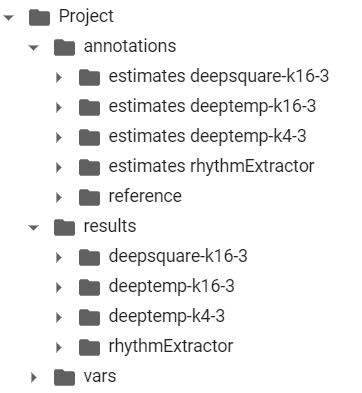

It is not necessary to create it in advance, it will be created during the running of the ntoebook.


With the pkl files with the results (*bptempos.pkl*, *cnnTempos.pkl* and *rhythmTempos.pkl*) and the JAMS files provided, there is no need to download the dataset and run the modeling, and it is possible to run the notebook from the **Save/Load the results** section.

## Install dependencies and import modules


### For dataset and analysis
The next two cells install the libraries to get the dataset and do the anlaysis.

In [27]:
# Install the mirdata library
print('Installing mirdata...')
!pip install mirdata
print('🎉 Done!')

Installing mirdata...
🎉 Done!


In [28]:
# Install essentia
print('Installing Essentia...')
!pip install essentia-tensorflow
print('🎉 Done!')

Installing Essentia...
🎉 Done!


### To evaluate the results
The next cells install the libraries to evaluate the results obtained.

In [29]:
# Install JAMS
print('Installing jams...')
!pip install jams
print('🎉 Done!')

Installing jams...
🎉 Done!


In [30]:
# Install tempo_eval and upgrade the needed modules to make it work properly
print('Installing tempo_eval and auxiliar dependencies... This may take various minutes')
!pip install git+https://github.com/tempoeval/tempo_eval
!pip install -U llvmlite==0.32.1
!pip install -U numba
print('🎉 Done!')

Installing tempo_eval and auxiliar dependencies... This may take various minutes
  Cloning https://github.com/tempoeval/tempo_eval to /tmp/pip-req-build-9hrrkjh1
  Running command git clone -q https://github.com/tempoeval/tempo_eval /tmp/pip-req-build-9hrrkjh1
  Using cached https://files.pythonhosted.org/packages/ad/5f/40d8e90f985a05133a8895fc454c6127ecec3de8b095dd35bba91382f803/pybtex-0.24.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/b7/201c9254ac0d2b8ffa3bb2d528d23a4130876d9ba90bc28e99633f323f17/pygal-2.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/13/be/775033ef08a8945bec6ad7973b161ca909f852442e0d7cfb8d1a214de1ac/pygam-0.8.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/b5/9b/7ad0a181b66d58334a2233f18fc8345e3ff17ea6f8db0eb59dc31182b6a9/numba-0.45.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/0a/76/9552dfc6b74c2d6c3f199e927d41998dc1e561b7cbe

Import the libraries and modules

In [31]:
import mirdata

import os
import zipfile

import essentia
from essentia.standard import *

import plotly.graph_objects as go
import numpy as np
import pickle

import jams

## Working folder path

First of all, please select the correct path to your working folder in Drive.

In [32]:
# Please put the correct path to your wotking folder
#############################################################
path = '/content/drive/MyDrive/Colab Notebooks/Project/'
#############################################################

## Collect data from Beatport dataset
The *beatport_EDM_key* is downloaded. Please check if the path to the dataset is correct (bpPath).

In [33]:
beatport = mirdata.initialize('beatport_key')
beatport.download()
beatport.validate()

###########################################
bpPath = '/root/mir_datasets/beatport_key'
###########################################

INFO: Downloading ['keys', 'metadata', 'audio'] to /root/mir_datasets/beatport_key
INFO: [keys] downloading keys.zip
376kB [00:01, 252kB/s]                            
INFO: [metadata] downloading original_metadata.zip
904kB [00:01, 520kB/s]                            
INFO: [audio] downloading audio.zip
1.98GB [08:38, 4.11MB/s]                            
100%|██████████| 1486/1486 [00:12<00:00, 119.06it/s]
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


##Tempo extraction

### Beatport tempos
In the next cell, the tempos from all the songs of the Beatport dataset with valid annotations will be saved. This will be taken as the ground truth.

In [34]:
# Creating the dictionary to save the tempos
bpTempos = {}
tracks = []

# Going through all the tempo annotations files
for dirs, subdirs, files in os.walk(os.path.join(bpPath, 'meta')):
  for file in files:
    if file.endswith('.json'):  # Just to ensure that it is a annotation json file
      # If the tempo is valid, saving the tempo data in the dictionary
      tempo = beatport.load_tempo(os.path.join(bpPath, 'meta', file))
      if tempo != 0 and tempo is not None:
        bpTempos[file.split('.json')[0]] = tempo
        tracks.append(file.split('.json')[0])

###TempoCNN tempos
####Load CNN models
First it is needed to download the CNN models

In [36]:
!curl -SLO https://essentia.upf.edu/models/tempo/tempocnn/deepsquare-k16-3.pb
!curl -SLO https://essentia.upf.edu/models/tempo/tempocnn/deeptemp-k4-3.pb
!curl -SLO https://essentia.upf.edu/models/tempo/tempocnn/deeptemp-k16-3.pb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4720k  100 4720k    0     0  1132k      0  0:00:04  0:00:04 --:--:-- 1136k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  144k  100  144k    0     0   127k      0  0:00:01  0:00:01 --:--:--  127k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1289k  100 1289k    0     0   662k      0  0:00:01  0:00:01 --:--:--  661k


In the next cell, the tempos obtained from the TempoCNN models will be saved.

In [72]:
# Creating the dictionary to save the tempos
cnnTempos ={'deepsquare-k16-3': {}, 'deeptemp-k4-3': {}, 'deeptemp-k16-3': {}}

# Creating the models, so there is no need to load them for each song
cnnModel1 = TempoCNN(graphFilename='deepsquare-k16-3.pb')
cnnModel2 = TempoCNN(graphFilename='deeptemp-k4-3.pb')
cnnModel3 = TempoCNN(graphFilename='deeptemp-k16-3.pb')

i = 0
for dirs, subdirs, files in os.walk(os.path.join(bpPath, 'audio')):
  for file in files:
    if file.endswith('.mp3') and file.split('.mp3')[0] in tracks: # Just to ensure that it is a music file
      # Loading the song
      audio = MonoLoader(filename=os.path.join(bpPath, 'audio', file), sampleRate=11025)()

      # Passing it through the models
      global_bpm1, local_bpm1, local_probs1 = cnnModel1(audio)
      global_bpm2, local_bpm2, local_probs2 = cnnModel2(audio)
      global_bpm3, local_bpm3, local_probs3 = cnnModel3(audio)

      # Saving the data in the dictionary
      cnnTempos['deepsquare-k16-3'][file.split('.mp3')[0]] = global_bpm1
      cnnTempos['deeptemp-k4-3'][file.split('.mp3')[0]] = global_bpm2
      cnnTempos['deeptemp-k16-3'][file.split('.mp3')[0]] = global_bpm3

      i+=1
      if i%20 == 0:
        print('Estimation for', str(i), 'files done')

print('\n', str(i), 'tracks estimated')

Estimation for 20 files done
Estimation for 40 files done
Estimation for 60 files done
Estimation for 80 files done
Estimation for 100 files done
Estimation for 120 files done
Estimation for 140 files done
Estimation for 160 files done
Estimation for 180 files done
Estimation for 200 files done
Estimation for 220 files done
Estimation for 240 files done
Estimation for 260 files done
Estimation for 280 files done
Estimation for 300 files done
Estimation for 320 files done
Estimation for 340 files done
Estimation for 360 files done
Estimation for 380 files done
Estimation for 400 files done
Estimation for 420 files done
Estimation for 440 files done
Estimation for 460 files done
Estimation for 480 files done
Estimation for 500 files done
Estimation for 520 files done
Estimation for 540 files done
Estimation for 560 files done
Estimation for 580 files done
Estimation for 600 files done
Estimation for 620 files done
Estimation for 640 files done
Estimation for 660 files done
Estimation for

###RhythmExtractor2013
In the next cell, the tempos obtained from the RhythmExtractor2013 model will be saved.

In [40]:
# Creating the dictionary to save the tempos
rhythmTempos = {}

i = 0
for dirs, subdirs, files in os.walk(os.path.join(bpPath, 'audio')):
  for file in files:
    if file.endswith('.mp3') and file.split('.mp3')[0] in tracks: # Just to ensure that it is a music file
      # Loading the song
      audio = MonoLoader(filename=os.path.join(bpPath, 'audio', file), sampleRate=44100)()

      # Passing it through the model
      bpm, beats, beats_confidence, _, beats_intervals = RhythmExtractor2013(method="degara")(audio)

      # Saving the data in the dictionary
      rhythmTempos[file.split('.mp3')[0]] = bpm

      i+=1
      if i%20 == 0:
        print('Estimation for', str(i), 'files done')

print('\n', str(i), 'tracks estimated')

Estimation for 20 files done
Estimation for 40 files done
Estimation for 60 files done
Estimation for 80 files done
Estimation for 100 files done
Estimation for 120 files done
Estimation for 140 files done
Estimation for 160 files done
Estimation for 180 files done
Estimation for 200 files done
Estimation for 220 files done
Estimation for 240 files done
Estimation for 260 files done
Estimation for 280 files done
Estimation for 300 files done
Estimation for 320 files done
Estimation for 340 files done
Estimation for 360 files done
Estimation for 380 files done
Estimation for 400 files done
Estimation for 420 files done
Estimation for 440 files done
Estimation for 460 files done
Estimation for 480 files done
Estimation for 500 files done
Estimation for 520 files done
Estimation for 540 files done
Estimation for 560 files done
Estimation for 580 files done
Estimation for 600 files done
Estimation for 620 files done
Estimation for 640 files done
Estimation for 660 files done
Estimation for

##Save/Load the results
The save section will save the data variables in the selected folder. If the *pkl* files are already in a folder, they can be loaded.

If you do not want neither save or load the results, you can go to the next part (JAMS).

---

Please comment/uncomment depending on the needs. Also check the path.


In [ ]:
# FOR SAVING RESULTS
"""
# Select the correct path to save the pkl files
#########################################################
if not os.path.exists(os.path.join(path, 'vars')):
  os.mkdir(os.path.join(path, 'vars'))
pathToSave = path + 'vars/'
#########################################################

# Save the results
saveBP = open(pathToSave+'bptempos.pkl', 'wb')
pickle.dump(bpTempos, saveBP)
saveBP.close()

saveCNN = open(pathToSave+'cnnTempos.pkl', 'wb')
pickle.dump(cnnTempos, saveCNN)
saveCNN.close()

saveRhythm = open(pathToSave+'rhythmTempos.pkl', 'wb')
pickle.dump(rhythmTempos, saveRhythm)
saveRhythm.close()

"""

# FOR LOADING RESULTS
# Select the correct path to the pkl files
#########################################################
pathToLoad = path + 'vars/'
#########################################################

# Load the results
loadBP = open(pathToLoad+'bptempos.pkl', 'rb')
bpTempos = pickle.load(loadBP)
loadBP.close()

loadCNN = open(pathToLoad+'cnnTempos.pkl', 'rb')
cnnTempos = pickle.load(loadCNN)
loadCNN.close()

loadRhythm = open(pathToLoad+'rhythmTempos.pkl', 'rb')
rhythmTempos = pickle.load(loadRhythm)
loadRhythm.close()

# Saving the keys of the tracks with a valid tempo.
tracks = []

# Going through all the tempo annotations files and saving only if it has a valid bpm
for key in bpTempos.keys():
  tempo = bpTempos[key]
  if tempo != 0 and tempo is not None:
    tracks.append(key)

# To save the results, comment until here!


##JAMS

### Creating the folders tree

In the next cell the folders to save all the data are created.

In [42]:
if not os.path.exists(os.path.join(path, 'annotations')):
  os.mkdir(os.path.join(path, 'annotations'))

pathToAnnottations = path + 'annotations/'
if not os.path.exists(os.path.join(pathToAnnottations, 'reference')):
  os.mkdir(os.path.join(pathToAnnottations, 'reference'))

if not os.path.exists(os.path.join(pathToAnnottations, 'estimates deepsquare-k16-3')):
  os.mkdir(os.path.join(pathToAnnottations, 'estimates deepsquare-k16-3'))

if not os.path.exists(os.path.join(pathToAnnottations, 'estimates deeptemp-k16-3')):
  os.mkdir(os.path.join(pathToAnnottations, 'estimates deeptemp-k16-3'))

if not os.path.exists(os.path.join(pathToAnnottations, 'estimates deeptemp-k4-3')):
  os.mkdir(os.path.join(pathToAnnottations, 'estimates deeptemp-k4-3'))

if not os.path.exists(os.path.join(pathToAnnottations, 'estimates rhythmExtractor')):
  os.mkdir(os.path.join(pathToAnnottations, 'estimates rhythmExtractor'))

### Generate JAMS files

In the next cells, the JAMS files are generated in order to use them in the *tempo_eval* framework.

---

Note that the JAMS files are provided, so there is no need to create them again.

In [51]:
# Reference annotations
jamsPath = pathToAnnottations + 'reference/'
i = 1

for track in tracks:
  tempo = bpTempos[track]
  jam = jams.JAMS()
  jam.file_metadata.duration = 0.0
  ann = jams.Annotation(namespace='tempo')
  ann.append(time=0, duration=0.0, value=int(tempo), confidence=1)

  ann.annotation_metadata = jams.AnnotationMetadata(data_source='mirdata', version='1.0', corpus='beatport_key')
  ann.annotation_metadata.curator = jams.Curator(name='Ruben', email='ruben.eguinoa01@estudiant.upf.edu')

  jam.annotations.append(ann)
  jam.save(jamsPath + track + '.jams')
  print(str(i), 'jams file done for', track)
  i += 1

1 jams file done for 5998113 The SmokeTonez - Lifetime Rave (Original Mix)
2 jams file done for 1598083 Aimee B - Kadabra (Original Mix)
3 jams file done for 3527620 Paimon, Place 2B - Quite (Original Mix)
4 jams file done for 298429 Marschmellows - Katsuo (Original Mix)
5 jams file done for 6317186 Sascha Sonido - Haywire (Detlef Remix)
6 jams file done for 1051007 D-Flected - Sombre (Original Mix)
7 jams file done for 6379893 KO TUNE - Urban Citizen (Original Mix)
8 jams file done for 5886473 Reprise Project - Restour (Again House Mix)
9 jams file done for 3994605 Siggatunez - Plan R (Remix)
10 jams file done for 4765342 Hotwire - Feel It (Original Mix)
11 jams file done for 299468 Plastic Operator - Couch (Original Mix)
12 jams file done for 4262086 Jon Game - Knobbin' Up (ft. U.M.B.R.O) (Original Mix)
13 jams file done for 4704294 Alvaro Wade, Raul Aguilar - Yamba (Original Mix)
14 jams file done for 297807 Polyharmonique - Luna (Original Mix)
15 jams file done for 753241 DNC, Lokt

In [52]:
# deepsquare-k16-3 annotations
jamsPath = pathToAnnottations + 'estimates deepsquare-k16-3/'
i = 1

for track in tracks:
  tempo = int(cnnTempos['deepsquare-k16-3'][track])
  jam = jams.JAMS()
  jam.file_metadata.duration = 0.0
  ann = jams.Annotation(namespace='tempo')
  ann.append(time=0, duration=0.0, value=tempo, confidence=1)

  ann.annotation_metadata = jams.AnnotationMetadata(data_source='deepsquare-k16-3', version='1.0', corpus='beatport_key')
  ann.annotation_metadata.curator = jams.Curator(name='Ruben', email='ruben.eguinoa01@estudiant.upf.edu')

  jam.annotations.append(ann)
  jam.save(jamsPath + track + '.jams')
  print(str(i), 'jams file done for', track)
  i += 1

1 jams file done for 5998113 The SmokeTonez - Lifetime Rave (Original Mix)
2 jams file done for 1598083 Aimee B - Kadabra (Original Mix)
3 jams file done for 3527620 Paimon, Place 2B - Quite (Original Mix)
4 jams file done for 298429 Marschmellows - Katsuo (Original Mix)
5 jams file done for 6317186 Sascha Sonido - Haywire (Detlef Remix)
6 jams file done for 1051007 D-Flected - Sombre (Original Mix)
7 jams file done for 6379893 KO TUNE - Urban Citizen (Original Mix)
8 jams file done for 5886473 Reprise Project - Restour (Again House Mix)
9 jams file done for 3994605 Siggatunez - Plan R (Remix)
10 jams file done for 4765342 Hotwire - Feel It (Original Mix)
11 jams file done for 299468 Plastic Operator - Couch (Original Mix)
12 jams file done for 4262086 Jon Game - Knobbin' Up (ft. U.M.B.R.O) (Original Mix)
13 jams file done for 4704294 Alvaro Wade, Raul Aguilar - Yamba (Original Mix)
14 jams file done for 297807 Polyharmonique - Luna (Original Mix)
15 jams file done for 753241 DNC, Lokt

In [53]:
# deeptemp-k16-3 annotations
jamsPath = pathToAnnottations + 'estimates deeptemp-k16-3/'
i = 1

for track in tracks:
  tempo = int(cnnTempos['deeptemp-k16-3'][track])
  jam = jams.JAMS()
  jam.file_metadata.duration = 0.0
  ann = jams.Annotation(namespace='tempo')
  ann.append(time=0, duration=0.0, value=tempo, confidence=1)

  ann.annotation_metadata = jams.AnnotationMetadata(data_source='deeptemp-k16-3', version='1.0', corpus='beatport_key')
  ann.annotation_metadata.curator = jams.Curator(name='Ruben', email='ruben.eguinoa01@estudiant.upf.edu')

  jam.annotations.append(ann)
  jam.save(jamsPath + track + '.jams')
  print(str(i), 'jams file done for', track)
  i += 1

1 jams file done for 5998113 The SmokeTonez - Lifetime Rave (Original Mix)
2 jams file done for 1598083 Aimee B - Kadabra (Original Mix)
3 jams file done for 3527620 Paimon, Place 2B - Quite (Original Mix)
4 jams file done for 298429 Marschmellows - Katsuo (Original Mix)
5 jams file done for 6317186 Sascha Sonido - Haywire (Detlef Remix)
6 jams file done for 1051007 D-Flected - Sombre (Original Mix)
7 jams file done for 6379893 KO TUNE - Urban Citizen (Original Mix)
8 jams file done for 5886473 Reprise Project - Restour (Again House Mix)
9 jams file done for 3994605 Siggatunez - Plan R (Remix)
10 jams file done for 4765342 Hotwire - Feel It (Original Mix)
11 jams file done for 299468 Plastic Operator - Couch (Original Mix)
12 jams file done for 4262086 Jon Game - Knobbin' Up (ft. U.M.B.R.O) (Original Mix)
13 jams file done for 4704294 Alvaro Wade, Raul Aguilar - Yamba (Original Mix)
14 jams file done for 297807 Polyharmonique - Luna (Original Mix)
15 jams file done for 753241 DNC, Lokt

In [54]:
# deeptemp-k4-3 annotations
jamsPath = pathToAnnottations +  'estimates deeptemp-k4-3/'
i = 1

for track in tracks:
  tempo = int(cnnTempos['deeptemp-k4-3'][track])
  jam = jams.JAMS()
  jam.file_metadata.duration = 0.0
  ann = jams.Annotation(namespace='tempo')
  ann.append(time=0, duration=0.0, value=tempo, confidence=1)

  ann.annotation_metadata = jams.AnnotationMetadata(data_source='deeptemp-k4-3', version='1.0', corpus='beatport_key')
  ann.annotation_metadata.curator = jams.Curator(name='Ruben', email='ruben.eguinoa01@estudiant.upf.edu')

  jam.annotations.append(ann)
  jam.save(jamsPath + track + '.jams')
  print(str(i), 'jams file done for', track)
  i += 1

1 jams file done for 5998113 The SmokeTonez - Lifetime Rave (Original Mix)
2 jams file done for 1598083 Aimee B - Kadabra (Original Mix)
3 jams file done for 3527620 Paimon, Place 2B - Quite (Original Mix)
4 jams file done for 298429 Marschmellows - Katsuo (Original Mix)
5 jams file done for 6317186 Sascha Sonido - Haywire (Detlef Remix)
6 jams file done for 1051007 D-Flected - Sombre (Original Mix)
7 jams file done for 6379893 KO TUNE - Urban Citizen (Original Mix)
8 jams file done for 5886473 Reprise Project - Restour (Again House Mix)
9 jams file done for 3994605 Siggatunez - Plan R (Remix)
10 jams file done for 4765342 Hotwire - Feel It (Original Mix)
11 jams file done for 299468 Plastic Operator - Couch (Original Mix)
12 jams file done for 4262086 Jon Game - Knobbin' Up (ft. U.M.B.R.O) (Original Mix)
13 jams file done for 4704294 Alvaro Wade, Raul Aguilar - Yamba (Original Mix)
14 jams file done for 297807 Polyharmonique - Luna (Original Mix)
15 jams file done for 753241 DNC, Lokt

In [55]:
# rhythmExtractor annotations
jamsPath = pathToAnnottations + 'estimates rhythmExtractor/'
i = 1

for track in tracks:
  tempo = int(rhythmTempos[track])
  jam = jams.JAMS()
  jam.file_metadata.duration = 0.0
  ann = jams.Annotation(namespace='tempo')
  ann.append(time=0, duration=0.0, value=tempo, confidence=1)

  ann.annotation_metadata = jams.AnnotationMetadata(data_source='rhythmExtractor2013', version='1.0', corpus='beatport_key')
  ann.annotation_metadata.curator = jams.Curator(name='Ruben', email='ruben.eguinoa01@estudiant.upf.edu')

  jam.annotations.append(ann)
  jam.save(jamsPath + track + '.jams')
  print(str(i), 'jams file done for', track)
  i += 1

1 jams file done for 5998113 The SmokeTonez - Lifetime Rave (Original Mix)
2 jams file done for 1598083 Aimee B - Kadabra (Original Mix)
3 jams file done for 3527620 Paimon, Place 2B - Quite (Original Mix)
4 jams file done for 298429 Marschmellows - Katsuo (Original Mix)
5 jams file done for 6317186 Sascha Sonido - Haywire (Detlef Remix)
6 jams file done for 1051007 D-Flected - Sombre (Original Mix)
7 jams file done for 6379893 KO TUNE - Urban Citizen (Original Mix)
8 jams file done for 5886473 Reprise Project - Restour (Again House Mix)
9 jams file done for 3994605 Siggatunez - Plan R (Remix)
10 jams file done for 4765342 Hotwire - Feel It (Original Mix)
11 jams file done for 299468 Plastic Operator - Couch (Original Mix)
12 jams file done for 4262086 Jon Game - Knobbin' Up (ft. U.M.B.R.O) (Original Mix)
13 jams file done for 4704294 Alvaro Wade, Raul Aguilar - Yamba (Original Mix)
14 jams file done for 297807 Polyharmonique - Luna (Original Mix)
15 jams file done for 753241 DNC, Lokt

##Results
In the next cell, the tempos obtained are compared to the ones of the beatport dataset. All the bpms are saved into the results dictionary. Also, if the predicted tempo is equal to the ground truth, we add it to the *good* array, where all the good predicted bpms are counted.

In [56]:
good = [[0 for j in range(2)] for i in range(4)]
results = {'truth': [], 'deepsquare-k16-3': [], 'deeptemp-k4-3': [], 'deeptemp-k16-3': [], 'rhythmTempos': []}

for track in tracks:
  if bpTempos[track] is not None:
    results['truth'].append(int(bpTempos[track]))
    results['deepsquare-k16-3'].append(int(cnnTempos['deepsquare-k16-3'][track]))
    results['deeptemp-k4-3'].append(int(cnnTempos['deeptemp-k4-3'][track]))
    results['deeptemp-k16-3'].append(int(cnnTempos['deeptemp-k16-3'][track]))
    results['rhythmTempos'].append(int(rhythmTempos[track]))

    if bpTempos[track] == int(cnnTempos['deepsquare-k16-3'][track]):
      good[0][0] += 1
    if bpTempos[track] == int(cnnTempos['deeptemp-k4-3'][track]):
      good[1][0] += 1
    if bpTempos[track] == int(cnnTempos['deeptemp-k16-3'][track]):
      good[2][0] += 1
    if bpTempos[track] == int(rhythmTempos[track]):
      good[3][0] += 1

good[0][1] = (good[0][0] / len(results['truth'])) * 100
good[1][1] = (good[1][0] / len(results['truth'])) * 100
good[2][1] = (good[2][0] / len(results['truth'])) * 100
good[3][1] = (good[3][0] / len(results['truth'])) * 100

A table with the exactitud of each model.

In [57]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'CNN deepsquare-k16-3', 'CNN deeptemp-k4-3', 'CNN deeptemp-k16-3', 'rhythmTempo2013']),
                 cells=dict(values=[['Exactitude', 'Exactitude %'], good[0], good[1], good[2], good[3]]))])

fig.show()

##Evaluation
The next cells create a document for each model with the framework *tempo_eval*. Please check the path to the jams files:

> --dir: the path to save the document

> --references: the path to the reference jams files

> --estimates: the path to the estimation jams files




In [59]:
# Creating the folder to save the results
if not os.path.exists(os.path.join(path, 'results')):
  os.mkdir(os.path.join(path, 'results'))

pathToResults = path + 'results/'

In [67]:
# deepsquare-k16-3
# Creating the folder to save the document
if not os.path.exists(os.path.join(pathToResults, 'deepsquare-k16-3')):
  os.mkdir(os.path.join(pathToResults, 'deepsquare-k16-3'))

# Creating the document
!tempo_eval --format html --dir '/content/drive/MyDrive/Colab Notebooks/MIR/Project/results/deepsquare-k16-3' \
--references '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/reference' \
--estimates '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/estimates deepsquare-k16-3'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
WARNING  Failed to read built-in estimates for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/estimates/beatport_key/)
WARNING  Failed to read built-in references for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/references/beatport_key/jams/)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tempi' of function 'sweet_octave'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/p

In [68]:
# deeptemp-k4-3
# Creating the folder to save the document
if not os.path.exists(os.path.join(pathToResults, 'deeptemp-k4-3')):
  os.mkdir(os.path.join(pathToResults, 'deeptemp-k4-3'))

# Creating the document
!tempo_eval --format html --dir '/content/drive/MyDrive/Colab Notebooks/MIR/Project/results/deeptemp-k4-3' \
--references '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/reference' \
--estimates '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/estimates deeptemp-k4-3'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
WARNING  Failed to read built-in estimates for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/estimates/beatport_key/)
WARNING  Failed to read built-in references for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/references/beatport_key/jams/)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tempi' of function 'sweet_octave'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/p

In [69]:
# deeptemp-k16-3
# Creating the folder to save the document
if not os.path.exists(os.path.join(pathToResults, 'deeptemp-k16-3')):
  os.mkdir(os.path.join(pathToResults, 'deeptemp-k16-3'))

# Creating the document
!tempo_eval --format html --dir '/content/drive/MyDrive/Colab Notebooks/MIR/Project/results/deeptemp-k16-3' \
--references '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/reference' \
--estimates '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/estimates deeptemp-k16-3'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
WARNING  Failed to read built-in estimates for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/estimates/beatport_key/)
WARNING  Failed to read built-in references for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/references/beatport_key/jams/)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tempi' of function 'sweet_octave'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/p

In [70]:
# rhythmExtractor
# Creating the folder to save the document
if not os.path.exists(os.path.join(pathToResults, 'rhythmExtractor')):
  os.mkdir(os.path.join(pathToResults, 'rhythmExtractor'))

# Creating the document
!tempo_eval --format html --dir '/content/drive/MyDrive/Colab Notebooks/MIR/Project/results/rhythmExtractor' \
--references '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/reference' \
--estimates '/content/drive/MyDrive/Colab Notebooks/MIR/Project/annotations/estimates rhythmExtractor'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
WARNING  Failed to read built-in estimates for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/estimates/beatport_key/)
WARNING  Failed to read built-in references for corpus 'beatport_key' (Annotations path does not exist: /usr/local/lib/python3.7/dist-packages/annotations/references/beatport_key/jams/)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tempi' of function 'sweet_octave'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../usr/local/lib/p

In the results folder 4 folders with the evaluation documents are saved in html format. To see them, download the folder and click in each *beatport_key.html* file.